# Which version of the website should we use?

Our team has been working on a redesign of the landing page. The team believes a new design will increase the number of people who click through and join the site. 

They have been testing the changes for a few weeks and now they want to measure the impact of the change. We need to determine if the increase can be due to random chance or if it is statistically significant.

## The data

- "treatment" - "yes" if the user saw the new version of the landing page, no otherwise.
- "new_images" - "yes" if the page used a new set of images, no otherwise.
- "converted" - 1 if the user joined the site, 0 otherwise.

The control group is those users with "no" in both columns: the old version with the old set of images.

## Exploratory data analysis

Let's observe the data and prepare it for the further analysis:

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [93]:
df = pd.read_csv('./data/redesign.csv')
df.head()

,treatment,new_images,converted
0,yes,yes,0
1,yes,yes,0
2,yes,yes,0
3,yes,no,0
4,no,yes,0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40484 entries, 0 to 40483
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   treatment   40484 non-null  object
 1   new_images  40484 non-null  object
 2   converted   40484 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 949.0+ KB


In [95]:
df.treatment = df.treatment.map({'yes': 1, 'no': 0})
df.new_images = df.new_images.map({'yes': 1, 'no': 0})

Let's check the sizes of the groups:

In [96]:
pd.pivot_table(df, index = 'treatment', columns = 'new_images', values = 'converted', aggfunc = 'count')

new_images,0,1
treatment,,
0,10121,10121
1,10121,10121


Let's also compare the conversion rate among the groups:

In [97]:
pd.pivot_table(df, index = 'treatment', columns = 'new_images', values = 'converted', aggfunc = 'mean')

new_images,0,1
treatment,,
0,0.107104,0.112538
1,0.120047,0.113724


As we can see above, the sizes of the 4 groups are equal, but conversion rates (CR) are slightly different: in the control group it's the lowest. The highest CR is in the group with new landing page and old images. 

But is this difference is statistically significant or it can be due to random chance? We will check it later. For now let's assign names to the groups:

- A - control group: no treatment (old landing page) + old images
- B - treatment (new landing page) + old images
- C - no treatment (old landing page) + new images
- D - treatment (new landing page) + new images

In [98]:
def assign_groups(row):
    if row.treatment == 0 and row.new_images == 0:
        return 'A'
    elif row.treatment == 1 and row.new_images == 0:
        return 'B'
    elif row.treatment == 0 and row.new_images == 1:
        return 'C'
    elif row.treatment == 1 and row.new_images == 1:
        return 'D'

In [99]:
df['group'] = df.apply(assign_groups, axis = 1)
df.head()

,treatment,new_images,converted,group
0,1,1,0,D
1,1,1,0,D
2,1,1,0,D
3,1,0,0,B
4,0,1,0,C


In [100]:
group_A = df[df.group == 'A'].converted
group_B = df[df.group == 'B'].converted
group_C = df[df.group == 'C'].converted
group_D = df[df.group == 'D'].converted

## Hypothesis testing

We have to measure the impact now to determine if the CR increase can be due to random chance or if it is statistically significant.

There are several approaches how to do it. We will try [Student’s T-Test](#students-t-test), [Mann-Whitney U Test](#mann-whitney-u-test), [Bootstrap](#bootstrap), [Permutation test](#permutation-test), [Proportions Z test](#proportions-z-test) and compare the results.

The **Null hypothesis**: there are no significant differencies between the control group (A) and other groups (B/C/D).

The **Alternate hypothesis**: there is significant difference between group A (control group) and group B/C/D.

### Student’s T Test

The T test tells us if the differences between group means are significant or those differences could have happened by chance. We can treat conversion rate in each group as a mean of the values in the column "converted".

The T test is usually used when data sets follow a normal distribution. But even handling non normal data we may still be able to run this test if our sample size is large enough. As we remember, our groups size is 10000+ examples, so we will try to use T test.

We have to perform 3 one side T tests (comparing if the group B/C/D means are higher than the mean of the control group A). When we run multiple tests, the p-values have to be adjusted for how many hypothesis tests we are running. We'll use Bonferroni correction for multiple testing, dividing the p-value by the number of tests.

In [101]:
alpha = 0.05 / 3

In [102]:
def one_side_ttest(group1, group2):
    results = st.ttest_ind(group1, group2)
    if (results.pvalue / 2 < alpha) and (group1.mean() < group2.mean()):
        print("p-value is {}. We're able to reject the Null Hypothesis, there is statistically significant difference.".format(round(results.pvalue/2, 4)))
    else:
    	print("p-value is {}. We're unable to reject the Null Hypothesis, there is no statistically significant difference.".format(round(results.pvalue/2, 4)))

#### A / B groups

In [103]:
one_side_ttest(group_A, group_B)

p-value is 0.0019. We're able to reject the Null Hypothesis, there is statistically significant difference.


#### A/C groups

In [104]:
one_side_ttest(group_A, group_C)

p-value is 0.1082. We're unable to reject the Null Hypothesis, there is no statistically significant difference.


#### A / D groups

In [105]:
one_side_ttest(group_A, group_D)

p-value is 0.0665. We're unable to reject the Null Hypothesis, there is no statistically significant difference.


### Mann-Whitney U Test

A non parametric test is one that doesn’t assume the data fits a specific distribution type. Non parametric tests include the Mann-Whitney U Test. We'll try U Test to make sure that we'll get the same result.

In [106]:
def mannwhitneyu_test(group1, group2):
    results = st.mannwhitneyu(group1, group2, alternative = 'less')
    if results.pvalue < alpha:
        print("p-value is {}. We're able to reject the Null Hypothesis, there is statistically significant difference.".format(round(results.pvalue, 4)))
    else:
    	print("p-value is {}. We're unable to reject the Null Hypothesis, there is no statistically significant difference.".format(round(results.pvalue, 4)))

#### A/B groups

In [107]:
mannwhitneyu_test(group_A, group_B)

p-value is 0.0019. We're able to reject the Null Hypothesis, there is statistically significant difference.


#### A/C groups

In [108]:
mannwhitneyu_test(group_A, group_C)

p-value is 0.1082. We're unable to reject the Null Hypothesis, there is no statistically significant difference.


#### A/D groups

In [109]:
mannwhitneyu_test(group_A, group_D)

p-value is 0.0665. We're unable to reject the Null Hypothesis, there is no statistically significant difference.


### Bootstrap

We can also try using bootstrap that doesn't make any assumptions about the data and can work with different metrics.

We will use Bootstrap to generate new samples from the existing ones to be able to estimate the CR distribution. We'll find 95% confidence intervals for CR of each group.

If CR confidence intervals of two groups compared don't intersect, there is statistically significant difference between the groups and we can reject the Null hypothesis. 

If they intersect, the difference can be due to random chance and we can't reject the Null hypothesis.

In [110]:
def bootstrap_plot(data1, data2, func=np.mean, size=1000, conf=0.95):
    
    length = max([len(data1), len(data2)])
    
    result1 = []
    result2 = []
    
    for i in range(size):
        sample1 = data1.sample(length, replace = True)
        sample2 = data2.sample(length, replace = True)
        
        result1.append(func(sample1))
        result2.append(func(sample2))
    
    q1 = (1 - conf) / 2
    q2 = 1 - (1 - conf) / 2
    
    result1 = pd.Series(result1)
    result2 = pd.Series(result2)
    
    conf_int_1 = result1.quantile([q1, q2])
    conf_int_2 = result2.quantile([q1, q2])
    
    plt.figure(figsize = (10, 4))
    ax = result1.plot(kind = 'hist', histtype = 'step', bins = 50, linewidth = 1.5, alpha = 0.7, label = 'group1', grid = True, legend = True)
    result2.plot(kind = 'hist', histtype = 'step', bins = 50, linewidth = 1.5, alpha = 0.7, label = 'group2', ax = ax, grid = True, legend = True)
    plt.vlines(conf_int_1, ymin = 0, ymax = 50, linestyle = '--', colors = 'blue')
    plt.vlines(conf_int_2, ymin = 0, ymax = 50, linestyle = '--', colors = 'green')
    plt.show()

#### A/B groups

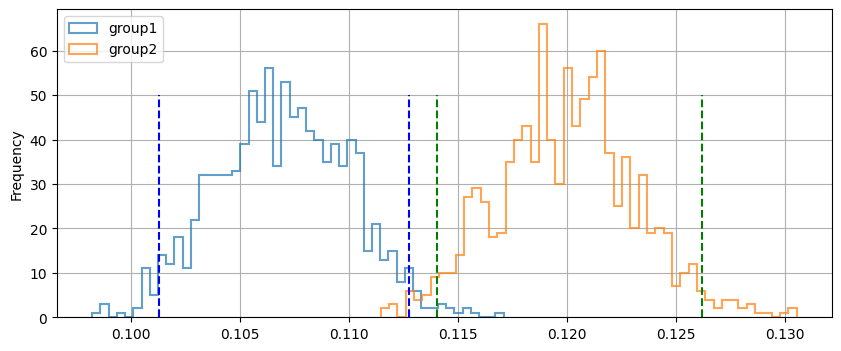

In [111]:
bootstrap_plot(group_A, group_B)

#### A/C groups

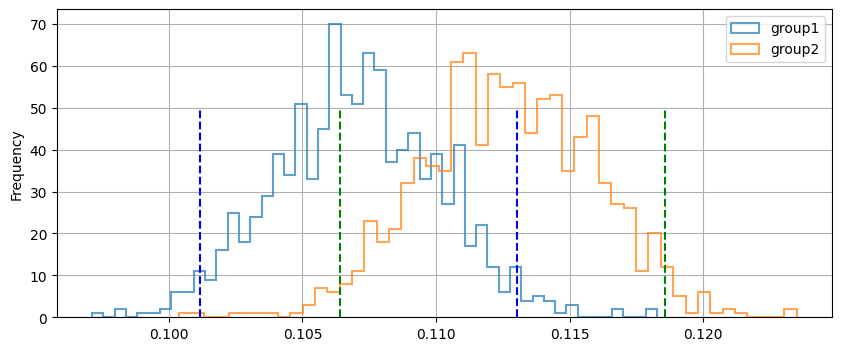

In [112]:
bootstrap_plot(group_A, group_C)

#### A/D groups

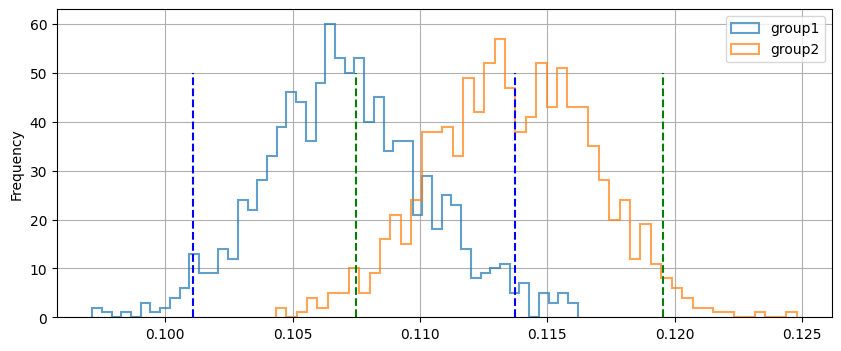

In [113]:
bootstrap_plot(group_A, group_D)

Now we can see it very clear on the graphs above that we can only reject the Null hypothesis for groups A/B, but not for A/C or A/D. 

Because the 95% confidence intervals of conversion rates in groups A and B don't intersect, while confidence intervals in other groups compared definetely do.

### Permutation test

Another way is to perform permutation test.

The process looks like this:
- we firstly find the absolute difference between the conversion rates in two groups;
- then, considering that our Null hypothesis is true and there is no significant difference, we combine the two groups;
- after that we generate 1000 new pairs of groups from the shuffled concatenated sample and find the difference between their conversion rates;
- we finally find the percentage of the samples where the difference was as extreme or more extreme than actual difference in the initial two groups compared;
- if the percentage is less than 5%, we'll reject the Null hypothesis.

In [114]:
def permutation_sample(data1, data2):
    
    data = np.concatenate([data1, data2])
    
    permuted_data = np.random.permutation(data)
    
    perm_sample1 = permuted_data[:len(data1)]
    perm_sample2 = permuted_data[len(data1):]
    
    return perm_sample1, perm_sample2

In [115]:
def perm_rep(data1, data2, func, size = 1):
    
    perm_replicates = np.empty(size)
    
    for i in range(size):
        perm_sample1, perm_sample2 = permutation_sample(data1, data2)
        
        perm_replicates[i] = func(perm_sample1, perm_sample2)
        
    return perm_replicates

In [116]:
def diff_of_means(data1, data2):
    diff = np.mean(data2) - np.mean(data1)
    return diff

In [117]:
def pertmutation_test(data1, data2, func, size = 1000):
    
    actual_diff = diff_of_means(data1, data2)
    
    perm_replicates = perm_rep(data1, data2, func, size)
    
    p = np.sum(perm_replicates >= actual_diff) / len(perm_replicates)
    
    if p < alpha:
        print("p-value is {}. We're able to reject the Null Hypothesis, there is statistically significant difference.".format(round(p, 4)))
    else:
    	print("p-value is {}. We're unable to reject the Null Hypothesis, there is no statistically significant difference.".format(round(p, 4)))

#### A/B groups

In [118]:
pertmutation_test(group_A, group_B, diff_of_means, 10000)

p-value is 0.0013. We're able to reject the Null Hypothesis, there is statistically significant difference.


#### A/C groups

In [119]:
pertmutation_test(group_A, group_C, diff_of_means, 10000)

p-value is 0.1141. We're unable to reject the Null Hypothesis, there is no statistically significant difference.


#### A/D groups

In [120]:
pertmutation_test(group_A, group_D, diff_of_means, 10000)

p-value is 0.069. We're unable to reject the Null Hypothesis, there is no statistically significant difference.


### Proportions Z test

We will now perform the proportions Z test to check whether there is a difference between two groups' proportions.

It's often used in marketing to evaluate a difference in conversion rates or other binary metrics.

We'll also compare the 95% confidence intarvals to see if there is intersection or not, as we have done before.

In [121]:
def proportion_test(data1, data2, ci_alpha = 0.05, alpha = 0.05):
    
    successes = [data1.sum(), data2.sum()]
    total_number = [data1.count(), data2.count()]
    
    result = proportions_ztest(successes, total_number, alternative='smaller')
    
    (lower_1,lower_2),(upper_1,upper_2) = proportion_confint(successes, total_number, alpha = ci_alpha)
    if result[1] < alpha:
        print('p-value is', round(result[1], 5))
        print("We're able to reject the Null Hypothesis, there is statistically significant difference.")
    else:
        print('p-value is', round(result[1], 5))
        print("We're unable to reject the Null Hypothesis, there is no statistically significant difference.")
        
    print('{}% confidence interval for first group: {} - {}'.format((1-ci_alpha)*100, round(lower_1, 3), round(upper_1, 3)))
    print('{}% confidence interval for second group: {} - {}'.format((1-ci_alpha)*100, round(lower_2, 3), round(upper_2, 3)))

#### A/B groups

In [122]:
proportion_test(group_A, group_B, alpha = alpha)

p-value is 0.00185
We're able to reject the Null Hypothesis, there is statistically significant difference.
95.0% confidence interval for first group: 0.101 - 0.113
95.0% confidence interval for second group: 0.114 - 0.126


#### A/C groups

In [123]:
proportion_test(group_A, group_C, alpha = alpha)

p-value is 0.10816
We're unable to reject the Null Hypothesis, there is no statistically significant difference.
95.0% confidence interval for first group: 0.101 - 0.113
95.0% confidence interval for second group: 0.106 - 0.119


#### A/D groups

In [124]:
proportion_test(group_A, group_D, alpha = alpha)

p-value is 0.06647
We're unable to reject the Null Hypothesis, there is no statistically significant difference.
95.0% confidence interval for first group: 0.101 - 0.113
95.0% confidence interval for second group: 0.108 - 0.12


### Results of the statistical tests

As we can see above, no matter which test we use to test the hypothesis, we always get the same result:

- there IS significant difference between the control group A and the group B;
- there is NO significant difference between the control group A and groups C/D;
- summing up these results, we'd recommend using **the new landing page with the old images**. 
This is the option that seems to be the best performing according to the results of the A/B tests.